In [1]:
%pip install -U kaleido
%pip install tqdm

# Configuration
FPS = 30
FFT_WINDOW_SECONDS = 0.25 # how many seconds of audio make up an FFT window

# Note range to display
FREQ_MIN = 10
FREQ_MAX = 1000

# Notes to display
TOP_NOTES = 3

# Names of the notes
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

# Output size. Generally use SCALE for higher res, unless you need a non-standard aspect ratio.
RESOLUTION = (1920, 1080)
SCALE = 2 # 0.5=QHD(960x540), 1=HD(1920x1080), 2=4K(3840x2160)

Note: you may need to restart the kernel to use updated packages.



In [3]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.io import wavfile # get the api
import os

!wget https://github.com/jeffheaton/present/raw/master/youtube/video/sample_audio/piano_c_major_scale.wav
AUDIO_FILE = "/piano_c_major_scale.wav"

fs, data = wavfile.read(AUDIO_FILE) # load the data

# Check if the audio data has more than one channel
if len(data.shape) > 1 and data.shape[1] > 1:
    audio = data.T[0] # this is a two channel soundtrack, get the first track
else:
    audio = data # this is a mono soundtrack

FRAME_STEP = (fs / FPS) # audio samples per video frame
FFT_WINDOW_SIZE = int(fs * FFT_WINDOW_SECONDS)
AUDIO_LENGTH = len(audio)/fs

'wget' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [Errno 2] No such file or directory: '/piano_c_major_scale.wav'

In [3]:
import plotly.graph_objects as go

def plot_fft(p, xf, fs, notes, dimensions=(960,540)):
  layout = go.Layout(
      title="frequency spectrum",
      autosize=False,
      width=dimensions[0],
      height=dimensions[1],
      xaxis_title="Frequency (note)",
      yaxis_title="Magnitude",
      font={'size' : 24}
  )

  fig = go.Figure(layout=layout,
                  layout_xaxis_range=[FREQ_MIN,FREQ_MAX],
                  layout_yaxis_range=[0,1]
                  )
  
  fig.add_trace(go.Scatter(
      x = xf,
      y = p))
  
  for note in notes:
    fig.add_annotation(x=note[0]+10, y=note[2],
            text=note[1],
            font = {'size' : 48},
            showarrow=False)
  return fig

def extract_sample(audio, frame_number):
  end = frame_number * FRAME_OFFSET
  begin = int(end - FFT_WINDOW_SIZE)

  if end == 0:
    # We have no audio yet, return all zeros (very beginning)
    return np.zeros((np.abs(begin)),dtype=float)
  elif begin<0:
    # We have some audio, padd with zeros
    return np.concatenate([np.zeros((np.abs(begin)),dtype=float),audio[0:end]])
  else:
    # Usually this happens, return the next sample
    return audio[begin:end]

def find_top_notes(fft,num):
  if np.max(fft.real)<0.001:
    return []

  lst = [x for x in enumerate(fft.real)]
  lst = sorted(lst, key=lambda x: x[1],reverse=True)

  idx = 0
  found = []
  found_note = set()
  while( (idx<len(lst)) and (len(found)<num) ):
    f = xf[lst[idx][0]]
    y = lst[idx][1]
    n = freq_to_number(f)
    n0 = int(round(n))
    name = note_name(n0)

    if name not in found_note:
      found_note.add(name)
      s = [f,note_name(n0),y]
      found.append(s)
    idx += 1
    
  return found

In [4]:
import numpy as np
import tqdm


# See https://newt.phys.unsw.edu.au/jw/notes.html
def freq_to_number(f): return 69 + 12*np.log2(f/440.0)
def number_to_freq(n): return 440 * 2.0**((n-69)/12.0)
def note_name(n): return NOTE_NAMES[n % 12] + str(int(n/12 - 1))

# Hanning window function
window = 0.5 * (1 - np.cos(np.linspace(0, 2*np.pi, FFT_WINDOW_SIZE, False)))

xf = np.fft.rfftfreq(FFT_WINDOW_SIZE, 1/fs)
FRAME_COUNT = int(AUDIO_LENGTH*FPS)
FRAME_OFFSET = int(len(audio)/FRAME_COUNT)

# Pass 1, find out the maximum amplitude so we can scale.
mx = 0
for frame_number in range(FRAME_COUNT):
  sample = extract_sample(audio, frame_number)

  fft = np.fft.rfft(sample * window)
  fft = np.abs(fft).real 
  mx = max(np.max(fft),mx)

print(f"Max amplitude: {mx}")

# Pass 2, produce the animation
print("Producing frames...")
for frame_number in tqdm.tqdm(range(FRAME_COUNT)):
  print(f"Processing frame {frame_number}...")  # Add this line
  sample = extract_sample(audio, frame_number)

  fft = np.fft.rfft(sample * window)
  fft = np.abs(fft) / mx 
     
  s = find_top_notes(fft,TOP_NOTES)

  fig = plot_fft(fft.real,xf,fs,s,RESOLUTION)
  fig.write_image(f"frame{frame_number}.png",scale=2)


Max amplitude: 31356926.787363894
Producing frames...


  0%|          | 0/223 [00:00<?, ?it/s]

Processing frame 0...


In [2]:
data_output

NameError: name 'data_output' is not defined

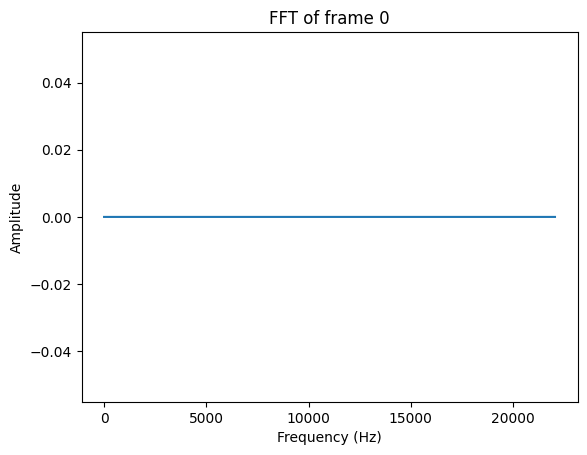